In [3]:
import sys
import os

sys.path.append("/Users/mb279434/Documents/stage/repos/argosim/src")

In [5]:
import numpy as np
import pandas as pd
from argosim import antenna_utils, imaging_utils, metrics_utils, data_utils

# Parameters
im_size = (542, 542)
fov = 0.3  
fov_size = (fov, fov)
sky_model = data_utils.n_source_sky(im_size, fov, [0.01, 0.005], [1., 1.])

# Number of configurations to generate
n_configs = 100

# Data storage
features = []
eccentricities = []

print("Generating data...\n")

for _ in range(n_configs):
    # Random antenna configuration parameters
    nE = np.random.randint(4, 16)
    nN = np.random.randint(4, 16)
    E_lim = np.random.uniform(50, 500)
    N_lim = np.random.uniform(200, 1000)

    # Antenna array
    antenna = antenna_utils.uni_antenna_array(n_antenna_E=nE, n_antenna_N=nN, E_lim=E_lim, N_lim=N_lim)
    b_enu = antenna_utils.get_baselines(antenna)

    # UV tracks
    track, _ = antenna_utils.uv_track_multiband(
        b_ENU=b_enu, track_time=3, n_times=10, f=1e9, df=1e8, n_freqs=10
    )

    # Compute dirty beam
    mask, _ = imaging_utils.grid_uv_samples(track, sky_uv_shape=im_size, fov_size=fov_size)
    dirty_beam = imaging_utils.uv2sky(mask)
    beam_shifted = np.fft.fftshift(np.abs(dirty_beam))  
    beam_shifted /= np.sum(beam_shifted)  

    # Fit + compute eccentricity
    try:
        fit = metrics_utils.fit_elliptical_beam(beam_shifted, threshold_ratio=0.5)
        eccentricity = fit["eccentricity"]
    except Exception as e:
        print("Error: ", e)
        continue

    # Store data
    features.append([nE, nN, E_lim, N_lim])
    # features.append(["Y-array", n_per_arm, radius])
    eccentricities.append(eccentricity)

# Create DataFrame
df = pd.DataFrame(features, columns=["nE", "nN", "E_lim", "N_lim"])
# df = pd.DataFrame(features, columns=["type", "n_per_arm", "radius"])
df["eccentricity"] = eccentricities

# Save dataset
df.to_csv("beam_config_dataset.csv", index=False)
print("Data saved to 'beam_config_dataset.csv'")


Generating data...

Data saved to 'beam_config_dataset.csv'


Model trained
Mean Absolute Error : 0.0711
R² Score            : 0.7964


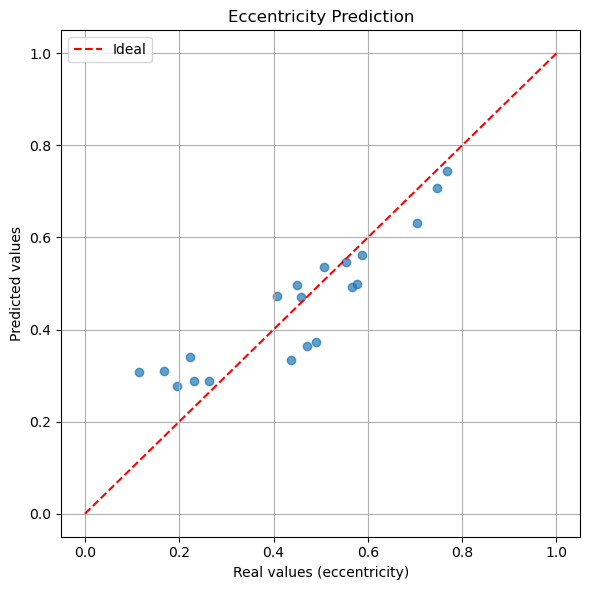

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("beam_config_dataset.csv")

X = df.drop(columns=["eccentricity"])
y = df["eccentricity"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model trained")
print(f"Mean Absolute Error : {mae:.4f}")
print(f"R² Score            : {r2:.4f}")

# Plot predictions vs real values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label="Ideal")
plt.xlabel("Real values (eccentricity)")
plt.ylabel("Predicted values")
plt.title("Eccentricity Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Top 5 optimal configurations:

     nE  nN       E_lim       N_lim  predicted_eccentricity
381  12   8  361.771969  379.066794                0.209618
806  13   7  349.896380  371.446896                0.213147
124  13  10  375.280785  427.184731                0.220478
809  11  10  341.563836  353.481366                0.222644
225   7  14  462.430304  488.537599                0.223838


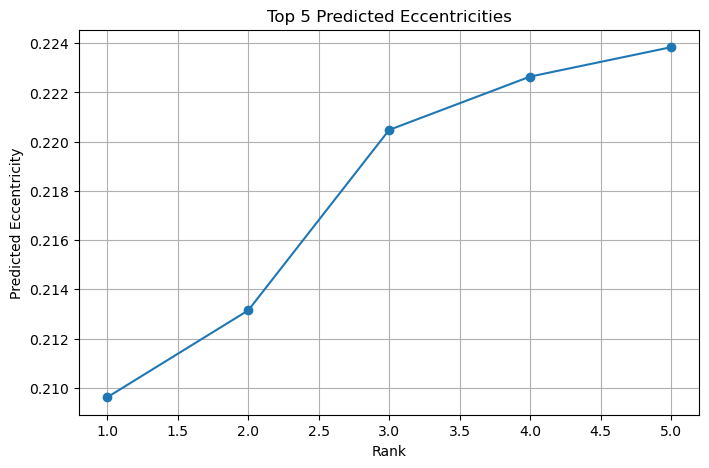

Top 5 configurations saved to 'top5_configurations.csv'


In [ ]:

# 1. Load the data and retrain the model
df = pd.read_csv("beam_config_dataset.csv")
X = df[["nE", "nN", "E_lim", "N_lim"]]
y = df["eccentricity"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 2. Generate new random configurations
n_candidates = 1000
configs = []
for _ in range(n_candidates):
    nE = np.random.randint(4, 16)
    nN = np.random.randint(4, 16)
    E_lim = np.random.uniform(50, 500)
    N_lim = np.random.uniform(200, 1200)
    configs.append([nE, nN, E_lim, N_lim])

# 3. Predict eccentricity
X_candidates = pd.DataFrame(configs, columns=["nE", "nN", "E_lim", "N_lim"])
y_pred = model.predict(X_candidates)
X_candidates["predicted_eccentricity"] = y_pred

# 4. Sort the configurations by ascending eccentricity
top5 = X_candidates.sort_values(by="predicted_eccentricity").head(5)

# 5. Display the top 5 configurations
print("Top 5 optimal configurations:\n")
print(top5)

# 6. Visualize
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 6), top5["predicted_eccentricity"], marker='o')
plt.title("Top 5 Predicted Eccentricities")
plt.xlabel("Rank")
plt.ylabel("Predicted Eccentricity")
plt.grid(True)
plt.show()

# 7. Save the top 5 to a CSV file
top5.rename(columns={"predicted_eccentricity": "eccentricity"}, inplace=True)
top5.to_csv("top5_configurations.csv", index=False)
print("Top 5 configurations saved to 'top5_configurations.csv'")
